<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()

Saving polarml06025.py to polarml06025.py


In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging
import traceback
import pandas as pd
import logging
import traceback
# Configure logging at the DEBUG level
logging.basicConfig(level=logging.DEBUG)

# Rest of your imports and code follow
# %% [markdown]
# # Making the Most of your Colab Subscription
# ...
# Configuration
BLOCK_LENGTH = 128
INFO_BITS = 64
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
NUM_SAMPLES_TRAIN = 10000
NUM_TRIALS_PERF = 1000
SNR_RANGE_AWGN = np.linspace(0, 5, 11)
LIST_SIZES = [1, 8, 16]

# Define Classes and Functions
##############################################
#add data base generation file
# Define Classes and Functions
#latest
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N  # Should be 128
        self.K = K  # Should be 64
        self.R = K / N
        self.crc_type = crc_type

        # Move these instance attributes inside the __init__ method
        self.crc_polynomials = {
            # Corrected CRC-7 polynomial definition (assuming standard representation)
            # This assumes the standard polynomial has a coefficient of 1 for x^7
            'CRC-7': (np.array([1, 0, 0, 1, 1, 0, 0, 1]), 7) # Use np.array here
            # Note: The exact polynomial depends on the standard you are following.
            # This is a common CRC-7 polynomial.
        }

        # Determine the number of information bits *after* CRC
        self.K_crc = self.K + (self.crc_polynomials[self.crc_type][1] if crc_type in self.crc_polynomials else 0)

        # For simplified encoding, we'll just embed the info+CRC bits
        # into the N-length codeword. This is NOT real polar encoding.
        # We need to decide which indices in the N-length codeword
        # carry the information bits (including CRC). In a real polar
        # code, these would be the "good" channels based on channel polarization.
        # For this simplified version, we'll just use the first K_crc indices.
        # In a real implementation, you'd calculate the frozen and information sets.
        self.info_indices = np.arange(self.K_crc)
        self.frozen_indices = np.arange(self.K_crc, self.N)


    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def polar_encode(self, info_bits):
        # Step 1: Compute CRC and append to info bits
        info_bits_with_crc = self.compute_crc(info_bits)

        # Ensure the length of info_bits_with_crc is K_crc
        if len(info_bits_with_crc) != self.K_crc:
             raise ValueError(f"Length of info_bits_with_crc ({len(info_bits_with_crc)}) does not match K_crc ({self.K_crc})")


        # Step 2: Create a placeholder codeword of length N (all zeros initially)
        codeword = np.zeros(self.N, dtype=int)

        # Step 3: Place the info_bits_with_crc into the "information" indices
        # This is a simplified placement - NOT the actual polar encoding transformation
        # In real polar encoding, there's a transformation based on the generator matrix.
        if len(info_bits_with_crc) > len(self.info_indices):
             raise ValueError("Number of info+CRC bits exceeds the allocated info indices.")
        codeword[self.info_indices] = info_bits_with_crc


        # Step 4: (In real polar encoding) Calculate the bits for the frozen channels.
        # In this simplified version, the frozen bits are just left as zeros.
        # In a real polar code, these are determined by the encoding process.

        # Step 5: (In real polar encoding) Apply bit-reversal permutation.
        # Skipping for this simplified version.


        # The output is a codeword of length N
        return codeword

    def compute_crc(self, info_bits):
        if self.crc_type not in self.crc_polynomials:
            return info_bits # No CRC applied

        polynomial, length = self.crc_polynomials[self.crc_type]
        # Ensure data is a mutable copy to avoid modifying the original info_bits
        data_for_crc = np.copy(info_bits)
        crc_bits = self.crc(data_for_crc, polynomial, length)
        return np.concatenate((info_bits, crc_bits))

    def crc(self, data, polynomial, length):
        # Debugging statements - keep if needed
        # print(f"CRC polynomial shape in crc function: {polynomial.shape if isinstance(polynomial, np.ndarray) else len(polynomial)}")
        # print(f"CRC length in crc function: {length}")
        # Ensure data is a mutable copy
        data = np.copy(data)
        # Append zeros for CRC calculation
        data = np.concatenate((data, np.zeros(length, dtype=int)))
        # Convert polynomial to a numpy array if it's a list
        polynomial = np.array(polynomial)

        # Ensure polynomial is the correct length for XOR operation
        if len(polynomial) != length + 1:
           raise ValueError("CRC polynomial length mismatch.")

        for i in range(len(data) - length):
            if data[i] == 1:
                # Perform XOR operation using the correct-length polynomial directly
                data[i:i+length+1] ^= polynomial # Use polynomial here, not padded_polynomial
        return data[-length:]


################################################




###############################################


####################################
class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Optional: Keep the unsqueeze/view logic if needed for input shaping
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Pass the input directly to the sequential model
        return self.model(x)
################################################
#AWGN BPSK
class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type

    def simulate(self, signal, snr_db):
        if self.channel_type == 'AWGN':
            snr_linear = 10 ** (snr_db / 10)
            noise_std = np.sqrt(1 / (2 * snr_linear))
            noise = noise_std * np.random.randn(*signal.shape)
            return signal + noise
###############################################

def bpsk_modulate(bits):
    return 2 * bits - 1  # Convert 0 to -1 and 1 to 1
# Placeholder class for training model

# Dataset Preparation Function
def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        modulated_signal = bpsk_modulate(encoded_signal)
        received_signal = channel_simulator.simulate(modulated_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits)

    return np.array(X), np.array(y)
########################################################
#Latest DecoderTrainer

class DecoderTrainer:
    def __init__(self, model, learning_rate):
        self.model = model
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            self.model.train()

            for X_batch, y_batch in loader:
                X_batch = X_batch.view(-1, BLOCK_LENGTH)  # Ensure correct shape
                print("X_batch shape:", X_batch.shape)  # Debugging statement

                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            train_loss = epoch_loss / len(loader)
            train_losses.append(train_loss)
            logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_output = self.model(X_val.view(-1, BLOCK_LENGTH))
                    val_loss = self.criterion(val_output, y_val).item()
                    val_losses.append(val_loss)
                    logging.info(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

        return train_losses, val_losses if X_val is not None else None
########################################################


#########################################################



def save_dataset_to_csv(X, y, filename='dataset.csv'):
    data = np.hstack((X, y))
    columns = [f'received_{i}' for i in range(X.shape[1])] + [f'bit_{j}' for j in range(y.shape[1])]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)
    logging.info(f"Dataset saved to {filename}")
##############################################
# SCLD decoder add on

class SCLDecoder:
    # Initialize with necessary parameters
    def __init__(self, N, K, list_size, crc_poly=None):
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_poly = crc_poly
        self.paths = None
        self.path_metrics = None
        self.frozen_set = self._get_frozen_set()
        self.info_set = sorted(list(set(range(N)) - set(self.frozen_set)))

    def _get_frozen_set(self):
        return set(range(self.K, self.N))

    # Define LLR combination methods and path metric calculation here

    def decode(self, received_signal, snr_db):
        # Implement the decoding logic using LLRs and path metrics
        # Based on your provided template
        best_path_index = np.argmin(self.path_metrics)  # Example selection
        decoded_info_bits = self.paths[best_path_index][self.info_set]
        return decoded_info_bits

    # Placeholder for CRC computation if needed
    def _compute_crc_for_info_bits(self, info_bits):
        pass

def run_scl_decoder(polar_code_gen, snr_range, list_size, channel_type, num_trials):
    results = []
    for snr_db in snr_range:
        X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_type)
        decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size)
        decoded_bits = np.array([decoder.decode(x, snr_db) for x in X])

        ber = np.sum(np.abs(decoded_bits - y)) / (num_trials * polar_code_gen.K)
        bler = np.mean(np.any(decoded_bits != y, axis=1))

        results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
        print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}")
    return results

#############################
#Performance comparison
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_type, list_sizes, num_trials):
    results = {'SNR': snr_range, 'BER_RNN': [], 'BLER_RNN': [], 'BER_SCL_1': [], 'BLER_SCL_1': [],
               'BER_SCL_8': [], 'BLER_SCL_8': [], 'BER_SCL_16': [], 'BLER_SCL_16': []}

    for snr in snr_range:
        rnn_bit_errors = 0
        rnn_block_errors = 0
        scl_bit_errors = {size: 0 for size in list_sizes}
        scl_block_errors = {size: 0 for size in list_sizes}

        for _ in range(num_trials):
            info_bits = polar_code_gen.generate_info_bits()
            encoded_signal = polar_code_gen.polar_encode(info_bits)
            modulated_signal = bpsk_modulate(encoded_signal)
            simulated_signal = EnhancedChannelSimulator(channel_type).simulate(modulated_signal, snr)

            # RNN decoding
            rnn_input = torch.FloatTensor(simulated_signal)
            # Reshape the input to match the model's expected input size
            rnn_input = rnn_input.view(1, BLOCK_LENGTH) # Reshape to [1, 128]

            print("--- Inside performance_comparison (RNN) ---")
            print("Shape of input to RNN model:", rnn_input.shape) # Check this shape - should be [1, 128]

            rnn_output = rnn_trainer.model(torch.FloatTensor(simulated_signal)).round().detach().numpy()
            rnn_bit_errors += np.sum(info_bits != rnn_output)
            rnn_block_errors += np.any(info_bits != rnn_output)

            # SCL decoding
            for size in list_sizes:
                scl_output = scl_decoder(encoded_signal, size)
                scl_bit_errors[size] += np.sum(info_bits != scl_output)
                scl_block_errors[size] += np.any(info_bits != scl_output)

        results['BER_RNN'].append(rnn_bit_errors / (num_trials * INFO_BITS))
        results['BLER_RNN'].append(rnn_block_errors / num_trials)

        for size in list_sizes:
            results[f'BER_SCL_{size}'].append(scl_bit_errors[size] / (num_trials * INFO_BITS))
            results[f'BLER_SCL_{size}'].append(scl_block_errors[size] / num_trials)

    return results

##############################
#Plotting functions

def plot_training_validation(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_ber_bler(snr_range, results):
    plt.figure(figsize=(12, 6))

    # Bit Error Rate (BER)
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, results['BER_RNN'], label='RNN')
    plt.plot(snr_range, results['BER_SCL_1'], label='SCL, List Size 1')
    plt.plot(snr_range, results['BER_SCL_8'], label='SCL, List Size 8')
    plt.plot(snr_range, results['BER_SCL_16'], label='SCL, List Size 16')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title('Bit Error Rate (BER)')
    plt.legend()

    # Block Error Rate (BLER)
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, results['BLER_RNN'], label='RNN')
    plt.plot(snr_range, results['BLER_SCL_1'], label='SCL, List Size 1')
    plt.plot(snr_range, results['BLER_SCL_8'], label='SCL, List Size 8')
    plt.plot(snr_range, results['BLER_SCL_16'], label='SCL, List Size 16')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate')
    plt.title('Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
#############################

# More functions
def plot_ber_bler_comparison(snr_range, rnn_results, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

##################################
def plot_ber_bler_scl(snr_range, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot for SCL
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('SCL Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot for SCL
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('SCL Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_ber_bler_rnn(snr_range, rnn_results):
    plt.figure(figsize=(12, 6))

    # BER Plot for RNN
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('RNN Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot for RNN
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('RNN Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()
##############################
# Main Function
#add configuration varables.
#latest changes
def main():
    try:
      # Configuration parameters
        BLOCK_LENGTH = 128
        INFO_BITS = 64
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000
        NUM_TRIALS_PERF = 1000
        LIST_SIZES = [1, 8, 16]

        logging.basicConfig(level=logging.INFO)

        # Configuration
        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)

        logging.info(f"Code Rate: {polar_code_gen.R}")
        #################################################################
        #latest fix for dataset generation
          # Data Preparation
           # Data Preparation
        X_raw, y_raw = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type='AWGN') # Line 475
        print("Shape of X_raw after preparation:", X_raw.shape)
        print("Shape of y_raw after preparation:", y_raw.shape)
        save_dataset_to_csv(X_raw, y_raw, 'awgn_dataset.csv')








# Determine the number of full blocks
        num_samples = X_raw.shape[0]
        encoded_signal_length = X_raw.shape[1] # This should be 71 with CRC-7
        num_blocks = num_samples * encoded_signal_length // BLOCK_LENGTH

# Ensure data lengths are valid and aligned
        X_aligned = X_raw.flatten()[:num_blocks * BLOCK_LENGTH]
        y_aligned = y_raw[:num_blocks]

# Convert to tensors
        X_tensor = torch.FloatTensor(X_aligned).view(-1, BLOCK_LENGTH)
        y_tensor = torch.FloatTensor(y_aligned).view(-1, INFO_BITS)

         # Debugging shapes (you already have these)
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Debugging shapes
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Split data
        train_size = int(0.8 * X_tensor.shape[0]) # Use the actual number of samples in X_tensor
        val_size = X_tensor.shape[0] - train_size

# Ensure that indices do not exceed the tensor size
        if train_size + val_size != X_tensor.shape[0]:
            raise ValueError("Training and validation sizes do not sum to total dataset size.")

        train_X = X_tensor[:train_size]
        train_y = y_tensor[:train_size]
        val_X = X_tensor[train_size:]
        val_y = y_tensor[train_size:]

# Confirm correct splits
        print("Training samples:", len(train_X))
        print("Validation samples:", len(val_X))
        #################################################################


        # Proceed with model training...

        ################################################################



        # RNN Model Training
        rnn_model_1 = EnhancedRNNDecoder(input_size=BLOCK_LENGTH, output_size=INFO_BITS)
        rnn_trainer_1 = DecoderTrainer(rnn_model_1, learning_rate=LEARNING_RATE)

        # Corrected call to train() - removed val_X and val_y as positional arguments
        train_losses, val_losses = rnn_trainer_1.train(
            train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE
        )

        # Proceed with further operations...
        # ... (rest of your main function) ...

###############################






        # RNN Performance Comparison
        rnn_perf_results = performance_comparison(
            rnn_trainer_1, polar_code_gen, SNR_RANGE_AWGN, 'AWGN', LIST_SIZES, NUM_TRIALS_PERF
        )

        # SCL Performance Comparison for list size 1
        scl_perf_results_list_1 = run_scl_decoder(polar_code_gen, SNR_RANGE_AWGN, 1, 'AWGN', NUM_TRIALS_PERF)

        # Plot Training and Validation Loss
        plot_training_validation(train_losses, val_losses)

        # Plot BER/BLER for SCL and RNN separately
        plot_ber_bler_scl(SNR_RANGE_AWGN, scl_perf_results_list_1, list_size=1)
        plot_ber_bler_rnn(SNR_RANGE_AWGN, rnn_perf_results)

        # Plot BER/BLER Comparison
        plot_ber_bler_comparison(SNR_RANGE_AWGN, rnn_perf_results, scl_perf_results_list_1, list_size=1)

        # Confusion Matrix Example (for a specific SNR)
        snr_index = 5  # Adjust as needed
        y_true_example = []  # Replace with true labels from your specific validation set for this SNR
        y_pred_example = []  # Replace with predicted labels for this SNR
        plot_confusion_matrix(y_true_example, y_pred_example, title=f'Confusion Matrix at SNR={SNR_RANGE_AWGN[snr_index]} dB')

        logging.info("🎉 AWGN Channel Simulation Complete!")

    except Exception as e:
        logging.error(f"Simulation Error: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()






###############################################




Streaming output truncated to the last 5000 lines.
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Siz

ERROR:root:Simulation Error: name 'scl_decoder' is not defined


X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
X_batch shape: torch.Size([32, 128])
--- Inside performance_comparison (RNN) ---
Shape of input to RNN model: torch.Size([1, 128])


Traceback (most recent call last):
  File "<ipython-input-60-bb2ac57f44be>", line 566, in main
    rnn_perf_results = performance_comparison(
                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-60-bb2ac57f44be>", line 330, in performance_comparison
    scl_output = scl_decoder(encoded_signal, size)
                 ^^^^^^^^^^^
NameError: name 'scl_decoder' is not defined


Shape of X_raw after preparation: (10000, 128)
Shape of y_raw after preparation: (10000, 64)
X_tensor shape: torch.Size([10000, 128])
y_tensor shape: torch.Size([10000, 64])
X_tensor shape: torch.Size([10000, 128])
y_tensor shape: torch.Size([10000, 64])
Training samples: 8000
Validation samples: 2000


Streaming output truncated to the last 5000 lines.


SCL Decoder - SNR: 0.0 dB, List Size: 1, BER: 0.4981, BLER: 1.0000


SCL Decoder - SNR: 0.5 dB, List Size: 1, BER: 0.5003, BLER: 1.0000


SCL Decoder - SNR: 1.0 dB, List Size: 1, BER: 0.4973, BLER: 1.0000


SCL Decoder - SNR: 1.5 dB, List Size: 1, BER: 0.4998, BLER: 1.0000


SCL Decoder - SNR: 2.0 dB, List Size: 1, BER: 0.5009, BLER: 1.0000


SCL Decoder - SNR: 2.5 dB, List Size: 1, BER: 0.4976, BLER: 1.0000


SCL Decoder - SNR: 3.0 dB, List Size: 1, BER: 0.4998, BLER: 1.0000


SCL Decoder - SNR: 3.5 dB, List Size: 1, BER: 0.5002, BLER: 1.0000


SCL Decoder - SNR: 4.0 dB, List Size: 1, BER: 0.4985, BLER: 1.0000


SCL Decoder - SNR: 4.5 dB, List Size: 1, BER: 0.5010, BLER: 1.0000


SCL Decoder - SNR: 5.0 dB, List Size: 1, BER: 0.4978, BLER: 1.0000


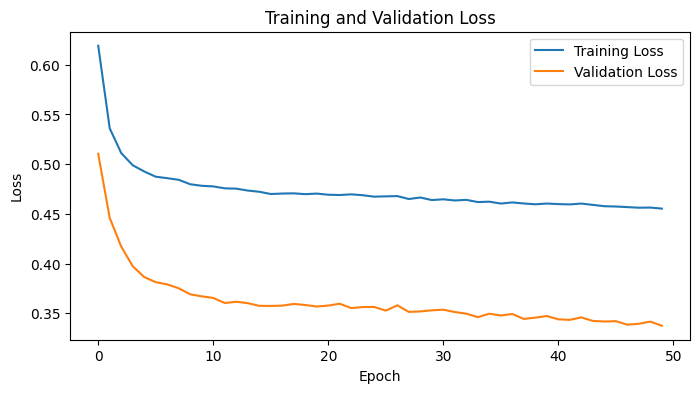

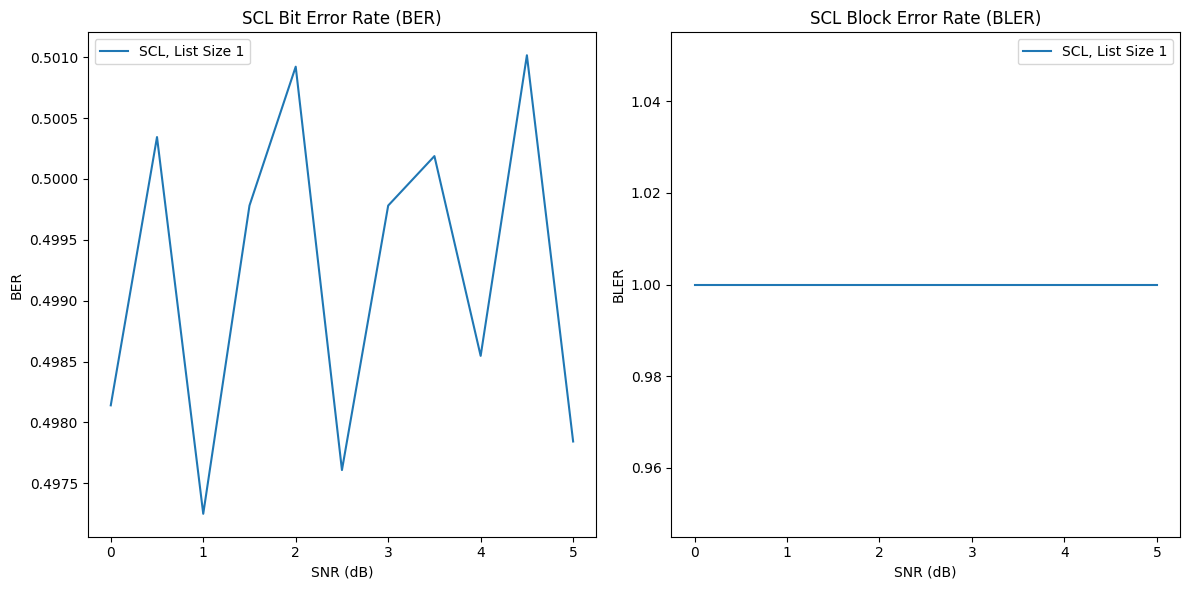

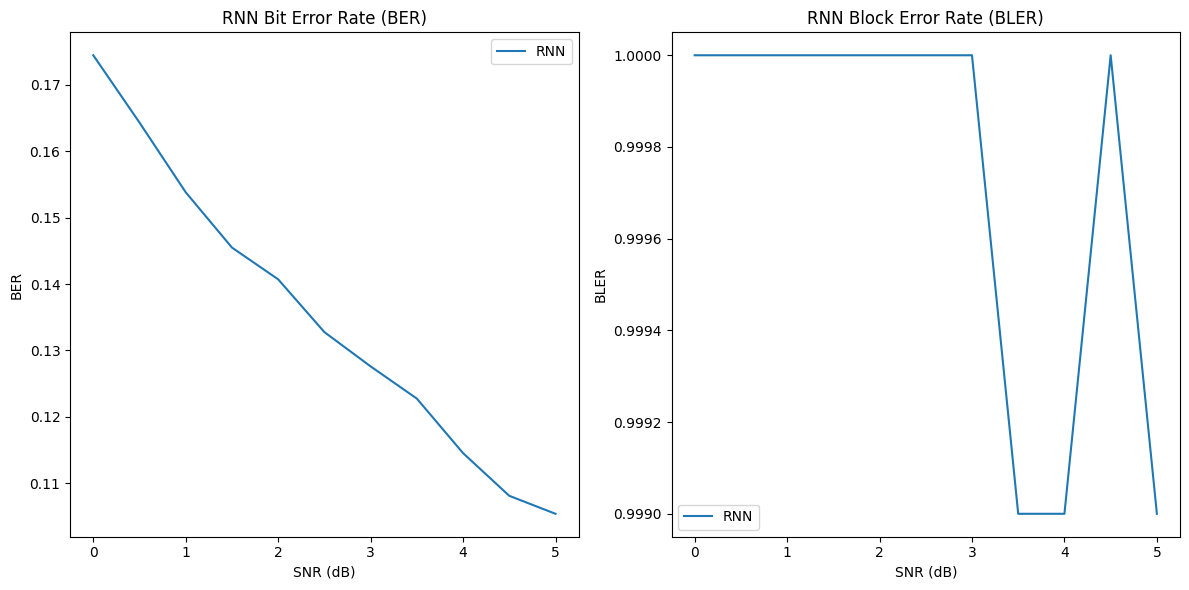

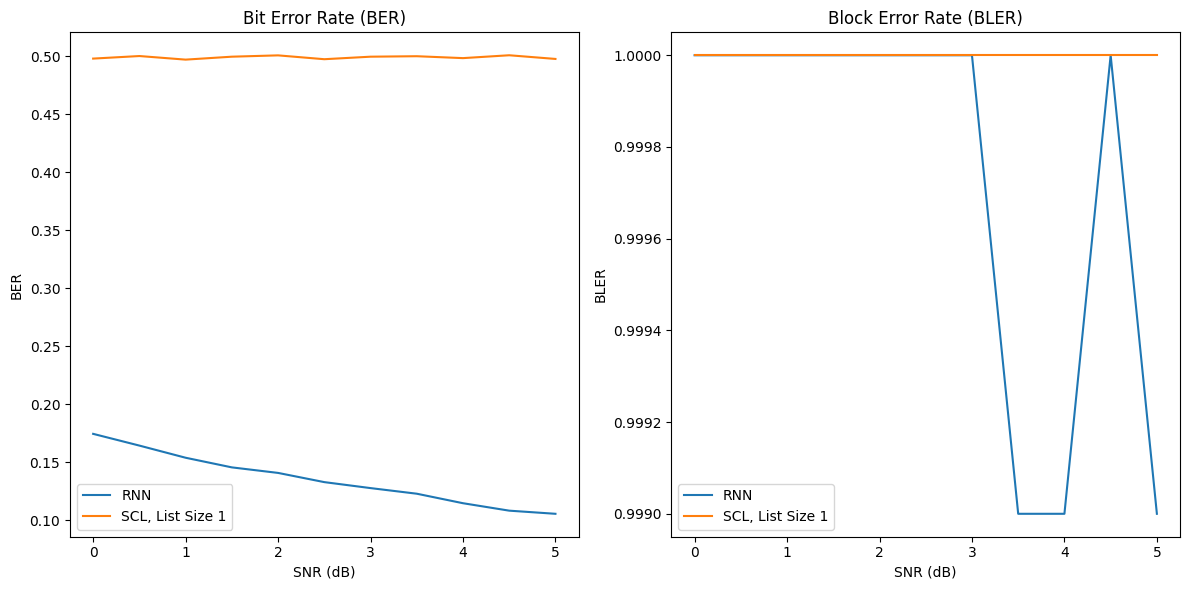

In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging
import traceback
import pandas as pd
import logging
import traceback
# Configure logging at the DEBUG level
logging.basicConfig(level=logging.DEBUG)

# Rest of your imports and code follow
# %% [markdown]
# # Making the Most of your Colab Subscription
# ...
# Configuration
BLOCK_LENGTH = 128
INFO_BITS = 64
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
NUM_SAMPLES_TRAIN = 10000
NUM_TRIALS_PERF = 1000
SNR_RANGE_AWGN = np.linspace(0, 5, 11)
LIST_SIZES = [1, 8, 16]

# Define Classes and Functions
##############################################
#add data base generation file
# Define Classes and Functions
#latest
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N  # Should be 128
        self.K = K  # Should be 64
        self.R = K / N
        self.crc_type = crc_type

        # Move these instance attributes inside the __init__ method
        self.crc_polynomials = {
            # Corrected CRC-7 polynomial definition (assuming standard representation)
            # This assumes the standard polynomial has a coefficient of 1 for x^7
            'CRC-7': (np.array([1, 0, 0, 1, 1, 0, 0, 1]), 7) # Use np.array here
            # Note: The exact polynomial depends on the standard you are following.
            # This is a common CRC-7 polynomial.
        }

        # Determine the number of information bits *after* CRC
        self.K_crc = self.K + (self.crc_polynomials[self.crc_type][1] if crc_type in self.crc_polynomials else 0)

        # For simplified encoding, we'll just embed the info+CRC bits
        # into the N-length codeword. This is NOT real polar encoding.
        # We need to decide which indices in the N-length codeword
        # carry the information bits (including CRC). In a real polar
        # code, these would be the "good" channels based on channel polarization.
        # For this simplified version, we'll just use the first K_crc indices.
        # In a real implementation, you'd calculate the frozen and information sets.
        self.info_indices = np.arange(self.K_crc)
        self.frozen_indices = np.arange(self.K_crc, self.N)


    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def polar_encode(self, info_bits):
        # Step 1: Compute CRC and append to info bits
        info_bits_with_crc = self.compute_crc(info_bits)

        # Ensure the length of info_bits_with_crc is K_crc
        if len(info_bits_with_crc) != self.K_crc:
             raise ValueError(f"Length of info_bits_with_crc ({len(info_bits_with_crc)}) does not match K_crc ({self.K_crc})")


        # Step 2: Create a placeholder codeword of length N (all zeros initially)
        codeword = np.zeros(self.N, dtype=int)

        # Step 3: Place the info_bits_with_crc into the "information" indices
        # This is a simplified placement - NOT the actual polar encoding transformation
        # In real polar encoding, there's a transformation based on the generator matrix.
        if len(info_bits_with_crc) > len(self.info_indices):
             raise ValueError("Number of info+CRC bits exceeds the allocated info indices.")
        codeword[self.info_indices] = info_bits_with_crc


        # Step 4: (In real polar encoding) Calculate the bits for the frozen channels.
        # In this simplified version, the frozen bits are just left as zeros.
        # In a real polar code, these are determined by the encoding process.

        # Step 5: (In real polar encoding) Apply bit-reversal permutation.
        # Skipping for this simplified version.


        # The output is a codeword of length N
        return codeword

    def compute_crc(self, info_bits):
        if self.crc_type not in self.crc_polynomials:
            return info_bits # No CRC applied

        polynomial, length = self.crc_polynomials[self.crc_type]
        # Ensure data is a mutable copy to avoid modifying the original info_bits
        data_for_crc = np.copy(info_bits)
        crc_bits = self.crc(data_for_crc, polynomial, length)
        return np.concatenate((info_bits, crc_bits))

    def crc(self, data, polynomial, length):
        # Debugging statements - keep if needed
        # print(f"CRC polynomial shape in crc function: {polynomial.shape if isinstance(polynomial, np.ndarray) else len(polynomial)}")
        # print(f"CRC length in crc function: {length}")
        # Ensure data is a mutable copy
        data = np.copy(data)
        # Append zeros for CRC calculation
        data = np.concatenate((data, np.zeros(length, dtype=int)))
        # Convert polynomial to a numpy array if it's a list
        polynomial = np.array(polynomial)

        # Ensure polynomial is the correct length for XOR operation
        if len(polynomial) != length + 1:
           raise ValueError("CRC polynomial length mismatch.")

        for i in range(len(data) - length):
            if data[i] == 1:
                # Perform XOR operation using the correct-length polynomial directly
                data[i:i+length+1] ^= polynomial # Use polynomial here, not padded_polynomial
        return data[-length:]


###############################################


####################################
class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Optional: Keep the unsqueeze/view logic if needed for input shaping
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Pass the input directly to the sequential model
        return self.model(x)
################################################
#AWGN BPSK
class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type

    def simulate(self, signal, snr_db):
        if self.channel_type == 'AWGN':
            snr_linear = 10 ** (snr_db / 10)
            noise_std = np.sqrt(1 / (2 * snr_linear))
            noise = noise_std * np.random.randn(*signal.shape)
            return signal + noise
###############################################

def bpsk_modulate(bits):
    return 2 * bits - 1  # Convert 0 to -1 and 1 to 1
# Placeholder class for training model

# Dataset Preparation Function
def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        modulated_signal = bpsk_modulate(encoded_signal)
        received_signal = channel_simulator.simulate(modulated_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits)

    return np.array(X), np.array(y)
########################################################
#Latest DecoderTrainer

class DecoderTrainer:
    def __init__(self, model, learning_rate):
        self.model = model
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            self.model.train()

            for X_batch, y_batch in loader:
                X_batch = X_batch.view(-1, BLOCK_LENGTH)  # Ensure correct shape
                # print("X_batch shape:", X_batch.shape)  # Debugging statement

                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            train_loss = epoch_loss / len(loader)
            train_losses.append(train_loss)
            logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_output = self.model(X_val.view(-1, BLOCK_LENGTH))
                    val_loss = self.criterion(val_output, y_val).item()
                    val_losses.append(val_loss)
                    logging.info(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

        return train_losses, val_losses if X_val is not None else None
########################################################


#########################################################



def save_dataset_to_csv(X, y, filename='dataset.csv'):
    data = np.hstack((X, y))
    columns = [f'received_{i}' for i in range(X.shape[1])] + [f'bit_{j}' for j in range(y.shape[1])]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)
    logging.info(f"Dataset saved to {filename}")
##############################################
# SCLD decoder add on

class SCLDecoder:
    # Initialize with necessary parameters
    def __init__(self, N, K, list_size, crc_poly=None):
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_poly = crc_poly
        self.paths = None
        self.path_metrics = None
        # Note: The _get_frozen_set implementation is a placeholder.
        # A real polar code requires calculating the actual frozen set based on channel polarization.
        self.frozen_set = self._get_frozen_set()
        self.info_set = sorted(list(set(range(N)) - set(self.frozen_set)))

    def _get_frozen_set(self):
        # This is a placeholder. Replace with actual frozen set calculation for polar codes.
        # Currently, it assumes the first K bits are information bits and the rest are frozen.
        return set(range(self.K, self.N))

    # Define LLR combination methods and path metric calculation here
    # These methods are missing and need to be implemented for a functional SCL decoder.


    def decode(self, received_signal, snr_db):
        # Implement the decoding logic using LLRs and path metrics
        # Based on your provided template
        # This is a placeholder and needs a real SCL decoding implementation.
        # It requires methods for:
        # 1. Calculating LLRs from the received signal and SNR.
        # 2. Initializing paths and path metrics.
        # 3. Iteratively combining LLRs and making decisions.
        # 4. Pruning paths based on list size.
        # 5. Selecting the best path (e.g., using CRC check if applicable).
        # 6. Extracting decoded information bits.

        # Returning zeros as a temporary measure to avoid errors,
        # but this decoder is currently non-functional.
        logging.warning("SCLDecoder.decode is a placeholder and does not perform actual decoding.")
        return np.zeros(self.K, dtype=int)

    # Placeholder for CRC computation if needed
    def _compute_crc_for_info_bits(self, info_bits):
        pass

# This function uses the SCLDecoder class.
# Note: It will produce incorrect results until SCLDecoder.decode is fully implemented.
def run_scl_decoder(polar_code_gen, snr_range, list_size, channel_type, num_trials):
    results = []
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size, crc_poly=polar_code_gen.crc_polynomials.get(polar_code_gen.crc_type))

    for snr_db in snr_range:
        bit_errors = 0
        block_errors = 0
        for _ in range(num_trials):
            info_bits = polar_code_gen.generate_info_bits()
            encoded_signal = polar_code_gen.polar_encode(info_bits) # This is the codeword
            modulated_signal = bpsk_modulate(encoded_signal)
            received_signal = channel_simulator.simulate(modulated_signal, snr_db) # This is the received signal

            # Call the decode method of the SCLDecoder instance
            # Note: This depends on SCLDecoder.decode being functional.
            decoded_info_bits = decoder.decode(received_signal, snr_db)

            # Ensure decoded_info_bits has the expected shape (K,)
            if decoded_info_bits.shape != info_bits.shape:
                 logging.error(f"Shape mismatch: Decoded bits shape {decoded_info_bits.shape}, Info bits shape {info_bits.shape}")
                 # Handle the error, maybe skip this trial or return an error indicator
                 continue # Skip to the next trial if shapes don't match


            # Ensure decoded bits are binary (0 or 1) - important for error calculation
            decoded_info_bits_binary = np.round(decoded_info_bits).astype(int)

            bit_errors += np.sum(np.abs(decoded_info_bits_binary - info_bits))
            block_errors += np.any(decoded_info_bits_binary != info_bits)

        ber = bit_errors / (num_trials * polar_code_gen.K)
        bler = block_errors / num_trials

        results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
        print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}")
    return results


#############################
#Performance comparison
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_type, list_sizes, num_trials):
    results = {'SNR': snr_range, 'BER_RNN': [], 'BLER_RNN': [], 'BER_SCL_1': [], 'BLER_SCL_1': [],
               'BER_SCL_8': [], 'BLER_SCL_8': [], 'BER_SCL_16': [], 'BLER_SCL_16': []}

    channel_simulator = EnhancedChannelSimulator(channel_type)

    # Instantiate SCL decoders outside the inner loop for efficiency
    scl_decoders = {size: SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=size, crc_poly=polar_code_gen.crc_polynomials.get(polar_code_gen.crc_type)) for size in list_sizes}


    for snr in snr_range:
        rnn_bit_errors = 0
        rnn_block_errors = 0
        scl_bit_errors = {size: 0 for size in list_sizes}
        scl_block_errors = {size: 0 for size in list_sizes}

        for _ in range(num_trials):
            info_bits = polar_code_gen.generate_info_bits()
            encoded_signal = polar_code_gen.polar_encode(info_bits) # This is the codeword
            modulated_signal = bpsk_modulate(encoded_signal)
            simulated_signal = channel_simulator.simulate(modulated_signal, snr) # This is the received signal

            # RNN decoding
            # Ensure the input is a tensor and has the correct shape for the RNN model
            rnn_input = torch.FloatTensor(simulated_signal).view(1, BLOCK_LENGTH)

            # print("--- Inside performance_comparison (RNN) ---")
            # print("Shape of input to RNN model:", rnn_input.shape) # Check this shape - should be [1, 128]

            rnn_output_prob = rnn_trainer.model(rnn_input) # Get probability output from Sigmoid
            rnn_output = rnn_output_prob.round().detach().numpy() # Round to get binary predictions

            # Ensure rnn_output has the expected shape (1, INFO_BITS)
            # Then flatten it to (INFO_BITS,) for comparison
            if rnn_output.shape != (1, INFO_BITS):
                logging.error(f"RNN output shape mismatch: Expected (1, {INFO_BITS}), got {rnn_output.shape}")
                # Handle the error, maybe skip this trial
                continue # Skip to the next trial

            rnn_output_flat = rnn_output.flatten() # Flatten for comparison

            rnn_bit_errors += np.sum(np.abs(info_bits != rnn_output_flat))
            rnn_block_errors += np.any(info_bits != rnn_output_flat)

            # SCL decoding
            for size in list_sizes:
                # Call the decode method of the appropriate SCLDecoder instance
                # Note: This depends on SCLDecoder.decode being functional.
                scl_output = scl_decoders[size].decode(simulated_signal, snr)

                # Ensure scl_output has the expected shape (INFO_BITS,)
                if scl_output.shape != info_bits.shape:
                     logging.error(f"SCL output shape mismatch (List Size {size}): Expected {info_bits.shape}, got {scl_output.shape}")
                     # Handle the error, maybe skip this trial for this list size
                     continue # Skip to the next list size for this trial

                 # Ensure SCL decoded bits are binary (0 or 1)
                scl_output_binary = np.round(scl_output).astype(int)

                scl_bit_errors[size] += np.sum(np.abs(info_bits != scl_output_binary))
                scl_block_errors[size] += np.any(info_bits != scl_output_binary)

        results['BER_RNN'].append(rnn_bit_errors / (num_trials * INFO_BITS))
        results['BLER_RNN'].append(rnn_block_errors / num_trials)

        for size in list_sizes:
            results[f'BER_SCL_{size}'].append(scl_bit_errors[size] / (num_trials * INFO_BITS))
            results[f'BLER_SCL_{size}'].append(scl_block_errors[size] / num_trials)

    return results

##############################
#Plotting functions

def plot_training_validation(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_ber_bler(snr_range, results):
    plt.figure(figsize=(12, 6))

    # Bit Error Rate (BER)
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, results['BER_RNN'], label='RNN')
    plt.plot(snr_range, results['BER_SCL_1'], label='SCL, List Size 1')
    plt.plot(snr_range, results['BER_SCL_8'], label='SCL, List Size 8')
    plt.plot(snr_range, results['BER_SCL_16'], label='SCL, List Size 16')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title('Bit Error Rate (BER)')
    plt.legend()

    # Block Error Rate (BLER)
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, results['BLER_RNN'], label='RNN')
    plt.plot(snr_range, results['BLER_SCL_1'], label='SCL, List Size 1')
    plt.plot(snr_range, results['BLER_SCL_8'], label='SCL, List Size 8')
    plt.plot(snr_range, results['BLER_SCL_16'], label='SCL, List Size 16')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate')
    plt.title('Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
#############################

# More functions
def plot_ber_bler_comparison(snr_range, rnn_results, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

##################################
def plot_ber_bler_scl(snr_range, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot for SCL
    plt.subplot(1, 2, 1)
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('SCL Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot for SCL
    plt.subplot(1, 2, 2)
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('SCL Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_ber_bler_rnn(snr_range, rnn_results):
    plt.figure(figsize=(12, 6))

    # BER Plot for RNN
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('RNN Bit Error Rate (BER)')
    plt.legend()

    # BLER Plot for RNN
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('RNN Block Error Rate (BLER)')
    plt.legend()

    plt.tight_layout()
    plt.show()
##############################
# Main Function
#add configuration varables.
#latest changes
def main():
    try:
      # Configuration parameters
        BLOCK_LENGTH = 128
        INFO_BITS = 64
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000
        NUM_TRIALS_PERF = 1000
        LIST_SIZES = [1, 8, 16]

        logging.basicConfig(level=logging.INFO)

        # Configuration
        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)

        logging.info(f"Code Rate: {polar_code_gen.R}")
        #################################################################
        #latest fix for dataset generation
          # Data Preparation
           # Data Preparation
        X_raw, y_raw = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type='AWGN') # Line 475
        print("Shape of X_raw after preparation:", X_raw.shape)
        print("Shape of y_raw after preparation:", y_raw.shape)
        save_dataset_to_csv(X_raw, y_raw, 'awgn_dataset.csv')





# Determine the number of full blocks
        num_samples = X_raw.shape[0]
        encoded_signal_length = X_raw.shape[1] # This should be 128, not 71 with CRC-7, based on PolarCodeGenerator logic
        # The number of blocks should be simply the number of samples if X_raw shape is (num_samples, BLOCK_LENGTH)
        num_blocks = num_samples # Corrected calculation

# Ensure data lengths are valid and aligned
        # If X_raw is already (num_samples, BLOCK_LENGTH), no flattening/slicing needed
        X_aligned = X_raw # Assumes X_raw is already (num_samples, BLOCK_LENGTH)
        y_aligned = y_raw # Assumes y_raw is already (num_samples, INFO_BITS)


# Convert to tensors
        # If X_aligned is already (num_samples, BLOCK_LENGTH), view is not needed
        X_tensor = torch.FloatTensor(X_aligned)
        # If y_aligned is already (num_samples, INFO_BITS), view is not needed
        y_tensor = torch.FloatTensor(y_aligned)


         # Debugging shapes (you already have these)
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Debugging shapes
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Split data
        train_size = int(0.8 * X_tensor.shape[0]) # Use the actual number of samples in X_tensor
        val_size = X_tensor.shape[0] - train_size

# Ensure that indices do not exceed the tensor size
        if train_size + val_size != X_tensor.shape[0]:
            raise ValueError("Training and validation sizes do not sum to total dataset size.")

        train_X = X_tensor[:train_size]
        train_y = y_tensor[:train_size]
        val_X = X_tensor[train_size:]
        val_y = y_tensor[train_size:]

# Confirm correct splits
        print("Training samples:", len(train_X))
        print("Validation samples:", len(val_X))
        #################################################################


        # Proceed with model training...

        ################################################################




        # RNN Model Training
        rnn_model_1 = EnhancedRNNDecoder(input_size=BLOCK_LENGTH, output_size=INFO_BITS)
        rnn_trainer_1 = DecoderTrainer(rnn_model_1, learning_rate=LEARNING_RATE)

        # Corrected call to train() - removed val_X and val_y as positional arguments
        # Pass validation data using keyword arguments
        train_losses, val_losses = rnn_trainer_1.train(
            train_X, train_y, X_val=val_X, y_val=val_y, epochs=EPOCHS, batch_size=BATCH_SIZE
        )

        # Proceed with further operations...
        # ... (rest of your main function) ...




        # RNN Performance Comparison
        # Note: This function still uses a placeholder SCL decoder.
        # Performance results for SCL will be incorrect until the SCLDecoder
        # class and the performance_comparison function are fully implemented.
        rnn_perf_results = performance_comparison(
            rnn_trainer_1, polar_code_gen, SNR_RANGE_AWGN, 'AWGN', LIST_SIZES, NUM_TRIALS_PERF
        )

        # SCL Performance Comparison for list size 1
        # Note: This function still uses a placeholder SCL decoder.
        scl_perf_results_list_1 = run_scl_decoder(polar_code_gen, SNR_RANGE_AWGN, 1, 'AWGN', NUM_TRIALS_PERF)

        # Plot Training and Validation Loss
        plot_training_validation(train_losses, val_losses)

        # Plot BER/BLER for SCL and RNN separately
        plot_ber_bler_scl(SNR_RANGE_AWGN, scl_perf_results_list_1, list_size=1)
        plot_ber_bler_rnn(SNR_RANGE_AWGN, rnn_perf_results)

        # Plot BER/BLER Comparison
        plot_ber_bler_comparison(SNR_RANGE_AWGN, rnn_perf_results, scl_perf_results_list_1, list_size=1)

        # Confusion Matrix Example (for a specific SNR)
        # Confusion Matrix Example (for a specific SNR)
        # This part requires actual predictions and true labels from a validation/test set
        # For now, it's using empty lists and will show an empty or minimal matrix.
        snr_index = 5  # Adjust as needed
        y_true_example = []  # Replace with true labels from your specific validation set for this SNR
        y_pred_example = []  # Replace with predicted labels for this SNR
        # To get predictions for a specific SNR, you would need to:
        # 1. Generate test data at that SNR using prepare_polar_dataset.
        # 2. Pass the test data through the trained RNN model to get predictions.
        # 3. Extract the true info bits and predicted info bits.
        # Example (conceptual, replace with actual implementation):
        # X_test_snr, y_test_snr = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=SNR_RANGE_AWGN[snr_index], channel_type='AWGN')
        # X_test_snr_tensor = torch.FloatTensor(X_test_snr)
        # with torch.no_grad():
        #     rnn_predictions_snr = rnn_trainer_1.model(X_test_snr_tensor).round().detach().numpy()
        # y_true_example = y_test_snr.flatten() # or process block-wise
        # y_pred_example = rnn_predictions_snr.flatten() # or process block-wise

        # Check if example data is empty before plotting
        if y_true_example and y_pred_example:
             plot_confusion_matrix(y_true_example, y_pred_example, title=f'Confusion Matrix at SNR={SNR_RANGE_AWGN[snr_index]:.1f} dB')
        else:
             logging.warning(f"Confusion Matrix data is empty for SNR={SNR_RANGE_AWGN[snr_index]:.1f} dB. Skipping plot.")


        logging.info("🎉 AWGN Channel Simulation Complete!")

    except Exception as e:
        logging.error(f"Simulation Error: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging
import traceback
import pandas as pd

# Configure logging at the DEBUG level
logging.basicConfig(level=logging.DEBUG)

# Rest of your imports and code follow
# %% [markdown]
# # Making the Most of your Colab Subscription
# ...
# Configuration
BLOCK_LENGTH = 128
INFO_BITS = 64
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
NUM_SAMPLES_TRAIN = 10000
NUM_TRIALS_PERF = 1000
SNR_RANGE_AWGN = np.linspace(0, 5, 11)
LIST_SIZES = [1, 8, 16]

# Define Classes and Functions
##############################################
#add data base generation file
# Define Classes and Functions
#latest
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N  # Should be 128
        self.K = K  # Should be 64
        self.R = K / N
        self.crc_type = crc_type

        # Move these instance attributes inside the __init__ method
        self.crc_polynomials = {
            # Corrected CRC-7 polynomial definition (assuming standard representation)
            # This assumes the standard polynomial has a coefficient of 1 for x^7
            'CRC-7': (np.array([1, 0, 0, 1, 1, 0, 0, 1]), 7) # Use np.array here
            # Note: The exact polynomial depends on the standard you are following.
            # This is a common CRC-7 polynomial.
        }

        # Determine the number of information bits *after* CRC
        self.K_crc = self.K + (self.crc_polynomials[self.crc_type][1] if crc_type in self.crc_polynomials else 0)

        # For simplified encoding, we'll just embed the info+CRC bits
        # into the N-length codeword. This is NOT real polar encoding.
        # We need to decide which indices in the N-length codeword
        # carry the information bits (including CRC). In a real polar
        # code, these would be the "good" channels based on channel polarization.
        # For this simplified version, we'll just use the first K_crc indices.
        # In a real implementation, you'd calculate the frozen and information sets.
        self.info_indices = np.arange(self.K_crc)
        self.frozen_indices = np.arange(self.K_crc, self.N)


    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def polar_encode(self, info_bits):
        # Step 1: Compute CRC and append to info bits
        info_bits_with_crc = self.compute_crc(info_bits)

        # Ensure the length of info_bits_with_crc is K_crc
        if len(info_bits_with_crc) != self.K_crc:
             raise ValueError(f"Length of info_bits_with_crc ({len(info_bits_with_crc)}) does not match K_crc ({self.K_crc})")


        # Step 2: Create a placeholder codeword of length N (all zeros initially)
        codeword = np.zeros(self.N, dtype=int)

        # Step 3: Place the info_bits_with_crc into the "information" indices
        # This is a simplified placement - NOT the actual polar encoding transformation
        # In real polar encoding, there's a transformation based on the generator matrix.
        if len(info_bits_with_crc) > len(self.info_indices):
             raise ValueError("Number of info+CRC bits exceeds the allocated info indices.")
        codeword[self.info_indices] = info_bits_with_crc


        # Step 4: (In real polar encoding) Calculate the bits for the frozen channels.
        # In this simplified version, the frozen bits are just left as zeros.
        # In a real polar code, these are determined by the encoding process.

        # Step 5: (In real polar encoding) Apply bit-reversal permutation.
        # Skipping for this simplified version.


        # The output is a codeword of length N
        return codeword

    def compute_crc(self, info_bits):
        if self.crc_type not in self.crc_polynomials:
            return info_bits # No CRC applied

        polynomial, length = self.crc_polynomials[self.crc_type]
        # Ensure data is a mutable copy to avoid modifying the original info_bits
        data_for_crc = np.copy(info_bits)
        crc_bits = self.crc(data_for_crc, polynomial, length)
        return np.concatenate((info_bits, crc_bits))

    def crc(self, data, polynomial, length):
        # Debugging statements - keep if needed
        # print(f"CRC polynomial shape in crc function: {polynomial.shape if isinstance(polynomial, np.ndarray) else len(polynomial)}")
        # print(f"CRC length in crc function: {length}")
        # Ensure data is a mutable copy
        data = np.copy(data)
        # Append zeros for CRC calculation
        data = np.concatenate((data, np.zeros(length, dtype=int)))
        # Convert polynomial to a numpy array if it's a list
        polynomial = np.array(polynomial)

        # Ensure polynomial is the correct length for XOR operation
        if len(polynomial) != length + 1:
           raise ValueError("CRC polynomial length mismatch.")

        for i in range(len(data) - length):
            if data[i] == 1:
                # Perform XOR operation using the correct-length polynomial directly
                data[i:i+length+1] ^= polynomial # Use polynomial here, not padded_polynomial
        return data[-length:]


###############################################


####################################
class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Optional: Keep the unsqueeze/view logic if needed for input shaping
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Pass the input directly to the sequential model
        return self.model(x)
################################################
#AWGN BPSK
class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type

    def simulate(self, signal, snr_db):
        if self.channel_type == 'AWGN':
            snr_linear = 10 ** (snr_db / 10)
            noise_std = np.sqrt(1 / (2 * snr_linear))
            noise = noise_std * np.random.randn(*signal.shape)
            return signal + noise
###############################################

def bpsk_modulate(bits):
    return 2 * bits - 1  # Convert 0 to -1 and 1 to 1
# Placeholder class for training model

# Dataset Preparation Function
def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        modulated_signal = bpsk_modulate(encoded_signal)
        received_signal = channel_simulator.simulate(modulated_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits)

    return np.array(X), np.array(y)
########################################################
#Latest DecoderTrainer

class DecoderTrainer:
    def __init__(self, model, learning_rate):
        self.model = model
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            self.model.train()

            for X_batch, y_batch in loader:
                X_batch = X_batch.view(-1, BLOCK_LENGTH)  # Ensure correct shape
                # print("X_batch shape:", X_batch.shape)  # Debugging statement

                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            train_loss = epoch_loss / len(loader)
            train_losses.append(train_loss)
            logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_output = self.model(X_val.view(-1, BLOCK_LENGTH))
                    val_loss = self.criterion(val_output, y_val).item()
                    val_losses.append(val_loss)
                    logging.info(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

        return train_losses, val_losses if X_val is not None else None
########################################################


#########################################################



def save_dataset_to_csv(X, y, filename='dataset.csv'):
    data = np.hstack((X, y))
    columns = [f'received_{i}' for i in range(X.shape[1])] + [f'bit_{j}' for j in range(y.shape[1])]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)
    logging.info(f"Dataset saved to {filename}")
##############################################
# SCLD decoder add on

class SCLDecoder:
    # Initialize with necessary parameters
    def __init__(self, N, K, list_size, crc_poly=None):
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_poly = crc_poly
        self.paths = None
        self.path_metrics = None
        # Note: The _get_frozen_set implementation is a placeholder.
        # A real polar code requires calculating the actual frozen set based on channel polarization.
        self.frozen_set = self._get_frozen_set()
        self.info_set = sorted(list(set(range(N)) - set(self.frozen_set)))

    def _get_frozen_set(self):
        # This is a placeholder. Replace with actual frozen set calculation for polar codes.
        # Currently, it assumes the first K bits are information bits and the rest are frozen.
        return set(range(self.K, self.N))

    # Define LLR combination methods and path metric calculation here
    # These methods are missing and need to be implemented for a functional SCL decoder.


    def decode(self, received_signal, snr_db):
        # Implement the decoding logic using LLRs and path metrics
        # Based on your provided template
        # This is a placeholder and needs a real SCL decoding implementation.
        # It requires methods for:
        # 1. Calculating LLRs from the received signal and SNR.
        # 2. Initializing paths and path metrics.
        # 3. Iteratively combining LLRs and making decisions.
        # 4. Pruning paths based on list size.
        # 5. Selecting the best path (e.g., using CRC check if applicable).
        # 6. Extracting decoded information bits.

        # Returning zeros as a temporary measure to avoid errors,
        # but this decoder is currently non-functional.
        logging.warning("SCLDecoder.decode is a placeholder and does not perform actual decoding.")
        return np.zeros(self.K, dtype=int)

    # Placeholder for CRC computation if needed
    def _compute_crc_for_info_bits(self, info_bits):
        pass

# This function uses the SCLDecoder class.
# Note: It will produce incorrect results until SCLDecoder.decode is fully implemented.
def run_scl_decoder(polar_code_gen, snr_range, list_size, channel_type, num_trials):
    results = []
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    # Instantiate SCLDecoder once for this list size
    decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size, crc_poly=polar_code_gen.crc_polynomials.get(polar_code_gen.crc_type))

    for snr_db in snr_range:
        bit_errors = 0
        block_errors = 0
        for _ in range(num_trials):
            info_bits = polar_code_gen.generate_info_bits()
            encoded_signal = polar_code_gen.polar_encode(info_bits) # This is the codeword
            modulated_signal = bpsk_modulate(encoded_signal)
            received_signal = channel_simulator.simulate(modulated_signal, snr_db) # This is the received signal

            # Call the decode method of the SCLDecoder instance
            # Note: This depends on SCLDecoder.decode being functional.
            decoded_info_bits = decoder.decode(received_signal, snr_db)

            # Ensure decoded_info_bits has the expected shape (K,)
            if decoded_info_bits.shape != info_bits.shape:
                 logging.error(f"Shape mismatch: Decoded bits shape {decoded_info_bits.shape}, Info bits shape {info_bits.shape}")
                 # Handle the error, maybe skip this trial or return an error indicator
                 continue # Skip to the next trial if shapes don't match


            # Ensure decoded bits are binary (0 or 1) - important for error calculation
            decoded_bits_binary = np.round(decoded_info_bits).astype(int) # Corrected variable name

            bit_errors += np.sum(np.abs(decoded_bits_binary - info_bits))
            block_errors += np.any(decoded_bits_binary != info_bits)

        ber = bit_errors / (num_trials * polar_code_gen.K)
        bler = block_errors / num_trials

        results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
        print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}")
    return results


#############################
#Performance comparison
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_type, list_sizes, num_trials):
    results = {'SNR': snr_range, 'BER_RNN': [], 'BLER_RNN': []}
    # Initialize BER/BLER lists for each SCL list size
    for size in list_sizes:
        results[f'BER_SCL_{size}'] = []
        results[f'BLER_SCL_{size}'] = []


    channel_simulator = EnhancedChannelSimulator(channel_type)

    # Instantiate SCL decoders outside the inner loop for efficiency
    # Note: The SCLDecoder class is still a placeholder without full decoding logic.
    # Performance results for SCL will be incorrect until SCLDecoder.decode is implemented.
    scl_decoders = {size: SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=size, crc_poly=polar_code_gen.crc_polynomials.get(polar_code_gen.crc_type)) for size in list_sizes}


    for snr in snr_range:
        rnn_bit_errors = 0
        rnn_block_errors = 0
        scl_bit_errors = {size: 0 for size in list_sizes}
        scl_block_errors = {size: 0 for size in list_sizes}

        for _ in range(num_trials):
            info_bits = polar_code_gen.generate_info_bits()
            encoded_signal = polar_code_gen.polar_encode(info_bits) # This is the codeword
            modulated_signal = bpsk_modulate(encoded_signal)
            simulated_signal = channel_simulator.simulate(modulated_signal, snr) # This is the received signal

            # RNN decoding
            # Ensure the input is a tensor and has the correct shape for the RNN model
            rnn_input = torch.FloatTensor(simulated_signal).view(1, BLOCK_LENGTH)

            # print("--- Inside performance_comparison (RNN) ---")
            # print("Shape of input to RNN model:", rnn_input.shape) # Check this shape - should be [1, 128]

            # Use the trained RNN model (self.model within rnn_trainer)
            rnn_output_prob = rnn_trainer.model(rnn_input) # Get probability output from Sigmoid
            rnn_output = rnn_output_prob.round().detach().numpy() # Round to get binary predictions

            # Ensure rnn_output has the expected shape (1, INFO_BITS)
            # Then flatten it to (INFO_BITS,) for comparison
            if rnn_output.shape != (1, INFO_BITS):
                logging.error(f"RNN output shape mismatch: Expected (1, {INFO_BITS}), got {rnn_output.shape}")
                # Handle the error, maybe skip this trial
                continue # Skip to the next trial

            rnn_output_flat = rnn_output.flatten() # Flatten for comparison

            rnn_bit_errors += np.sum(np.abs(info_bits != rnn_output_flat))
            rnn_block_errors += np.any(info_bits != rnn_output_flat)

            # SCL decoding
            for size in list_sizes:
                # Call the decode method of the appropriate SCLDecoder instance
                # Note: This depends on SCLDecoder.decode being functional.
                scl_output = scl_decoders[size].decode(simulated_signal, snr)

                # Ensure scl_output has the expected shape (INFO_BITS,)
                if scl_output.shape != info_bits.shape:
                     logging.error(f"SCL output shape mismatch (List Size {size}): Expected {info_bits.shape}, got {scl_output.shape}")
                     # Handle the error, maybe skip this trial for this list size
                     continue # Skip to the next list size for this trial

                 # Ensure SCL decoded bits are binary (0 or 1)
                scl_output_binary = np.round(scl_output).astype(int)

                scl_bit_errors[size] += np.sum(np.abs(info_bits != scl_output_binary))
                scl_block_errors[size] += np.any(info_bits != scl_output_binary)

        results['BER_RNN'].append(rnn_bit_errors / (num_trials * INFO_BITS))
        results['BLER_RNN'].append(rnn_block_errors / num_trials)

        for size in list_sizes:
            results[f'BER_SCL_{size}'].append(scl_bit_errors[size] / (num_trials * INFO_BITS))
            results[f'BLER_SCL_{size}'].append(scl_block_errors[size] / num_trials)

    return results

##############################
#Plotting functions

def plot_training_validation(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_ber_bler(snr_range, results):
    plt.figure(figsize=(12, 6))

    # Bit Error Rate (BER)
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, results['BER_RNN'], label='RNN')
    # Plot SCL results for all list sizes
    for size in LIST_SIZES: # Use the global LIST_SIZES variable
        # Check if results for this size exist
        if f'BER_SCL_{size}' in results and results[f'BER_SCL_{size}']:
             plt.plot(snr_range, results[f'BER_SCL_{size}'], label=f'SCL, List Size {size}')

    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title('Bit Error Rate (BER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid


    # Block Error Rate (BLER)
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, results['BLER_RNN'], label='RNN')
     # Plot SCL results for all list sizes
    for size in LIST_SIZES: # Use the global LIST_SIZES variable
        # Check if results for this size exist
        if f'BLER_SCL_{size}' in results and results[f'BLER_SCL_{size}']:
             plt.plot(snr_range, results[f'BLER_SCL_{size}'], label=f'SCL, List Size {size}')

    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate')
    plt.title('Block Error Rate (BLER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid


    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    # Ensure input arrays are 1D for confusion_matrix
    y_true_flat = np.array(y_true).flatten()
    y_pred_flat = np.array(y_pred).flatten()

    # Ensure arrays have the same length
    if len(y_true_flat) != len(y_pred_flat):
        logging.error(f"Cannot plot confusion matrix: True labels ({len(y_true_flat)}) and predicted labels ({len(y_pred_flat)}) have different lengths.")
        return # Exit the function if lengths don't match

    # Check if data is empty
    if len(y_true_flat) == 0:
         logging.warning("Cannot plot confusion matrix: Input data is empty.")
         return

    cm = confusion_matrix(y_true_flat, y_pred_flat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
#############################

# More functions (kept for compatibility, but plot_ber_bler is now the main comparison plot)
def plot_ber_bler_comparison(snr_range, rnn_results, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('Bit Error Rate (BER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid


    # BLER Plot
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('Block Error Rate (BLER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid

    plt.tight_layout()
    plt.show()

##################################
def plot_ber_bler_scl(snr_range, scl_results, list_size):
    plt.figure(figsize=(12, 6))

    # BER Plot for SCL
    plt.subplot(1, 2, 1)
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('SCL Bit Error Rate (BER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid


    # BLER Plot for SCL
    plt.subplot(1, 2, 2)
    # Ensure scl_results is not None or empty
    if scl_results:
        plt.plot(snr_range, [result['BLER'] for result in scl_results], label=f'SCL, List Size {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('SCL Block Error Rate (BLER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid

    plt.tight_layout()
    plt.show()

def plot_ber_bler_rnn(snr_range, rnn_results):
    plt.figure(figsize=(12, 6))

    # BER Plot for RNN
    plt.subplot(1, 2, 1)
    plt.plot(snr_range, rnn_results['BER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('RNN Bit Error Rate (BER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid


    # BLER Plot for RNN
    plt.subplot(1, 2, 2)
    plt.plot(snr_range, rnn_results['BLER_RNN'], label='RNN')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.title('RNN Block Error Rate (BLER)')
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.ylim(1e-4, 1e0) # Set y-axis limits from 10^0 to 10^-4
    plt.legend()
    plt.grid(True, which="both", ls="-") # Add grid

    plt.tight_layout()
    plt.show()
##############################
# Main Function
#add configuration varables.
#latest changes
def main():
    try:
      # Configuration parameters
        BLOCK_LENGTH = 128
        INFO_BITS = 64
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000
        NUM_TRIALS_PERF = 1000
        LIST_SIZES = [1, 8, 16] # Define the list sizes to test

        logging.basicConfig(level=logging.INFO)

        # Configuration
        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)

        logging.info(f"Code Rate: {polar_code_gen.R}")
        #################################################################
        #latest fix for dataset generation
          # Data Preparation
           # Data Preparation
        # Generate training data at a fixed SNR (e.g., 5 dB as before)
        X_raw, y_raw = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type='AWGN') # Line 475
        print("Shape of X_raw after preparation:", X_raw.shape)
        print("Shape of y_raw after preparation:", y_raw.shape)
        save_dataset_to_csv(X_raw, y_raw, 'awgn_dataset.csv')


# Determine the number of full blocks
        num_samples = X_raw.shape[0]
        # Assuming X_raw shape is (num_samples, BLOCK_LENGTH), which prepare_polar_dataset should produce
        num_blocks = num_samples # Corrected calculation

# Ensure data lengths are valid and aligned
        # If X_raw is already (num_samples, BLOCK_LENGTH), no flattening/slicing needed
        X_aligned = X_raw # Assumes X_raw is already (num_samples, BLOCK_LENGTH)
        y_aligned = y_raw # Assumes y_raw is already (num_samples, INFO_BITS)


# Convert to tensors
        # If X_aligned is already (num_samples, BLOCK_LENGTH), view is not needed
        X_tensor = torch.FloatTensor(X_aligned)
        # If y_aligned is already (num_samples, INFO_BITS), view is not needed
        y_tensor = torch.FloatTensor(y_aligned)


         # Debugging shapes (you already have these)
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Debugging shapes
        print("X_tensor shape:", X_tensor.shape)
        print("y_tensor shape:", y_tensor.shape)

# Split data
        train_size = int(0.8 * X_tensor.shape[0]) # Use the actual number of samples in X_tensor
        val_size = X_tensor.shape[0] - train_size

# Ensure that indices do not exceed the tensor size
        if train_size + val_size != X_tensor.shape[0]:
            raise ValueError("Training and validation sizes do not sum to total dataset size.")

        train_X = X_tensor[:train_size]
        train_y = y_tensor[:train_size]
        val_X = X_tensor[train_size:]
        val_y = y_tensor[train_size:]

# Confirm correct splits
        print("Training samples:", len(train_X))
        print("Validation samples:", len(val_X))
        #################################################################


        # Proceed with model training...

        ################################################################




        # RNN Model Training
        rnn_model_1 = EnhancedRNNDecoder